# Data module

In [2]:
import pandas as pd
import numpy as np
import random

def modificar_dataframe(df, pct_filas = 0.1, pct_cambio = 0.2):
    # Número de filas y columnas del DataFrame
    num_filas = len(df)
    num_columnas = len(df.columns[:-1])
    
    # Seleccionar aleatoriamente el 10% de las filas
    num_filas_modificar = int(num_filas * pct_filas)
    filas_modificar = np.random.choice(df.index, size=num_filas_modificar, replace=False)
    
    # Seleccionar aleatoriamente un número de columnas (entre 1 y el número total de columnas)
    num_columnas_modificar = np.random.randint(1, num_columnas + 1)
    columnas_modificar = np.random.choice(df.columns[:-1], size=num_columnas_modificar, replace=False)
    columnas_modificar = ['Speed (cm/s)']

    # Modificar los valores de las filas y columnas seleccionadas en un 15%
    for fila in filas_modificar:
        for columna in columnas_modificar:
            df.at[fila, columna] = int(df.at[fila, columna] * (1 + pct_cambio * random.uniform(1, 1.5)))
            df.at[fila, 'label'] = 1

    df.to_csv('tmp.csv')
            
    return df

def vicomtech_data(pct_cambio, pct_filas = 0.05):
    dataframe = pd.read_csv('/home/nics/Repos/5G-Tactile-IDS/data/RecFile_1_20240712_095926_CAM_Generator_output_list.csv')
    dataframe['label'] = 0
    # dataframe = dataframe.drop('Timestamp (UNIX) ', axis=1)
    dataframe = dataframe.drop('Unnamed: 0', axis=1)

    modificar_dataframe(dataframe, pct_filas=pct_filas, pct_cambio=pct_cambio)

    return dataframe

## Scoring

In [8]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

def evaluate(Y, Y_pred):

    roc_auc = roc_auc_score(Y, Y_pred)
    print(f'ROC: {roc_auc}')

    # Compute confusion matrix
    cm = confusion_matrix(Y, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

# SUOD

In [43]:
import os
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from combo.models.score_comb import majority_vote, maximization, average

# suppress warnings
import warnings

warnings.filterwarnings("ignore")

from suod.models.base import SUOD
from suod.utils.utility import get_estimators_small

def run(X, Y):
    # standardize data to be digestible for most algorithms
    X = StandardScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = \
        train_test_split(X, Y, test_size=0.4, random_state=42)

    contamination = Y.sum() / len(Y) if Y.sum() / len(Y) != 0 else 0.123
    print('contamination',contamination)
    base_estimators = get_estimators_small(contamination)

    model = SUOD(base_estimators=base_estimators, n_jobs=-1, bps_flag=True,
                 contamination=contamination, approx_flag_global=True, verbose=False)

    model.fit(X)  # fit all models with X
    model.approximate(X)  # conduct model approximation if it is enabled
    predicted_labels = model.predict(X)  # predict labels
    return majority_vote(predicted_labels)


## Run

In [44]:
df = vicomtech_data(pct_cambio = 0.3, pct_filas = 0.03)

# df = df[['Timestamp (UNIX) ', 'Speed (cm/s)', 'label']]
df = df.head(1000)
tmp = df['Timestamp (UNIX) ']
tmp2 = df['label']
df = df.diff().fillna(0)
df['Timestamp (UNIX) '] = tmp
df['label'] = tmp2

X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
Y_pred = run(X, Y)

contamination 0.033
RandomForestRegressor()



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

## Confusion Matrix

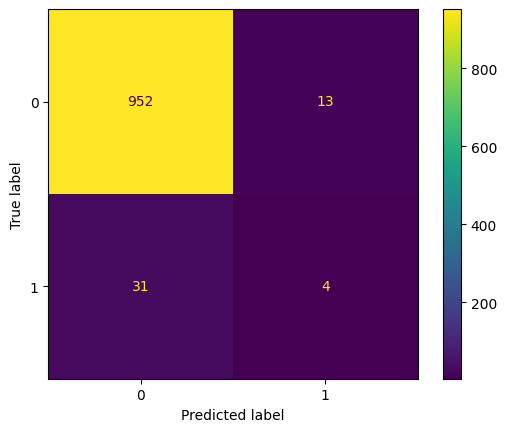

In [24]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(Y, Y_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Mapa de puntos con Timestamp y Speed

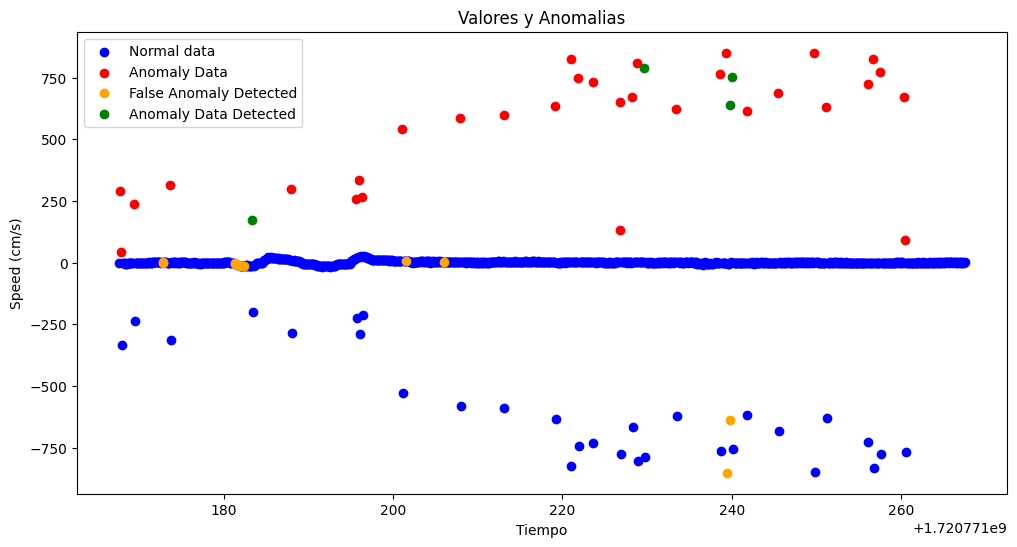

In [25]:
from matplotlib.patches import Circle
import pandas as pd
import matplotlib.pyplot as plt

for i, valor in enumerate(Y_pred):
    if valor == 1 and Y[i] == 1:
        df.at[i, 'label'] = 2
    if valor == 1 and Y[i] == 0:
        df.at[i, 'label'] = 3

# Crear el mapa de puntos
plt.figure(figsize=(12, 6))
colors = {4: 'yellow', 3: 'orange', 2: 'green', 1: 'red', 0: 'blue'}  # Asignar colores según el valor de la tercera columna
labels = {0: "Normal data", 1: "Anomaly Data", 2: "Anomaly Data Detected", 3: "False Anomaly Detected"}

for c in df['label'].unique():
    subset = df[df['label'] == c]
    plt.scatter(subset['Timestamp (UNIX) '], subset['Speed (cm/s)'], label=labels[c], color=colors[c])

plt.xlabel('Tiempo')
plt.ylabel('Speed (cm/s)')
plt.title('Valores y Anomalias')
plt.legend()
plt.show()

## SUOD usando n valores anterirores y haciendo mayoria: (WIP)

In [10]:
import os
import sys

from sklearn.preprocessing import StandardScaler

from combo.models.score_comb import majority_vote

# suppress warnings
import warnings

warnings.filterwarnings("ignore")

# temporary solution for relative imports in case combo is not installed
# if combo is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from suod.models.base import SUOD
from suod.utils.utility import get_estimators_small

def run(X, Y):
    # standardize data to be digestible for most algorithms
    X = StandardScaler().fit_transform(X)

    contamination = Y.sum() / len(Y) if Y.sum() / len(Y) != 0 else 0.1
    base_estimators = get_estimators_small(contamination)

    model = SUOD(base_estimators=base_estimators, n_jobs=-1, bps_flag=True,
                 contamination=contamination, approx_flag_global=True, verbose=False)

    model.fit(X)  # fit all models with X
    model.approximate(X)  # conduct model approximation if it is enabled
    predicted_labels = model.predict(X)  # predict labels

    return majority_vote(predicted_labels)

RandomForestRegressor()



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.5s finished


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.5s finished


majority vote ROC:0.5678, precision @ rank n:0.3587


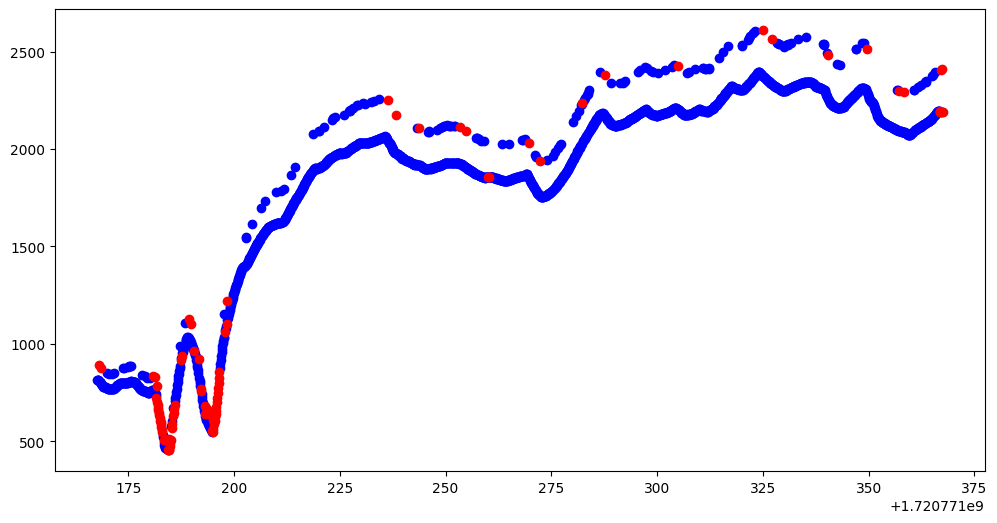

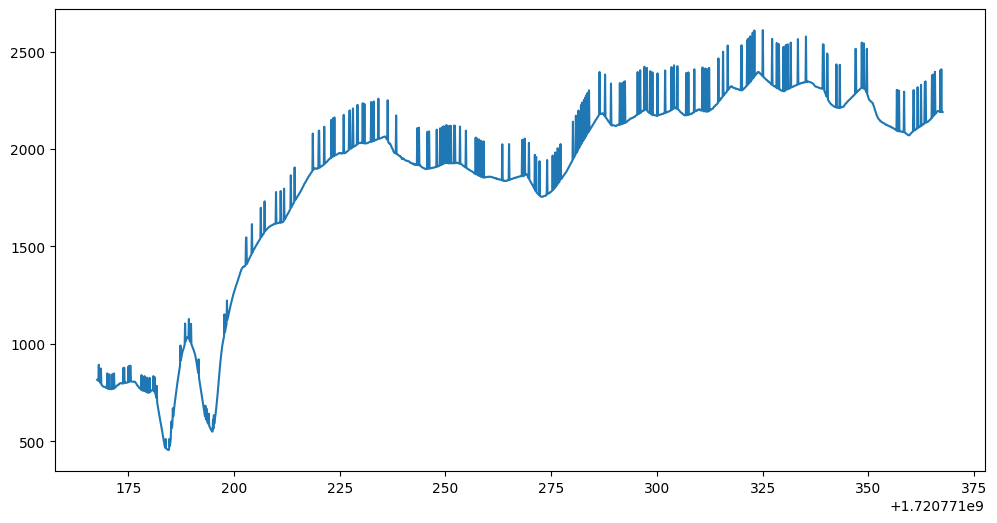

In [11]:
from pyod.utils.data import evaluate_print

df = vicomtech_data(pct_cambio = 0.1, pct_filas = 0.1)

df = df[['Timestamp (UNIX) ', 'Speed (cm/s)', 'label']]
df = df.head(2000)

# Calcular el array de divisiones entre el valor de una fila y la siguiente
df_model = pd.DataFrame()
df_model['div'] = np.zeros(len(df['Speed (cm/s)'][:-1]))
for n in range(1, 10):
    speed_shifted = df['Speed (cm/s)'].shift(-n)
    divisiones = abs(1 - (df['Speed (cm/s)'][:-n] / speed_shifted[:-n]))
    df_model['div'] += divisiones

df_model['label'] = df.iloc[:, -1][:-1]

# plt.figure(figsize=(12, 6))
# plt.scatter(df['Timestamp (UNIX) '][:-1], df_proc['Speed (cm/s)'])
# plt.show()

X = df_model.iloc[:, :-1].fillna(0)
Y = df_model['label']

Y_pred = run(X, Y)

evaluate_print('majority vote', Y, Y_pred)

colors = {1: 'red', 0: 'blue'}  # Asignar colores según el valor de la tercera columna
plt.figure(figsize=(12, 6))
for c in Y.unique():
    subset = df[:-1][Y_pred == c]
    plt.scatter(subset['Timestamp (UNIX) '], subset['Speed (cm/s)'], label='A', color=colors[c])
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp (UNIX) '], df['Speed (cm/s)'])
plt.show()

# IForest

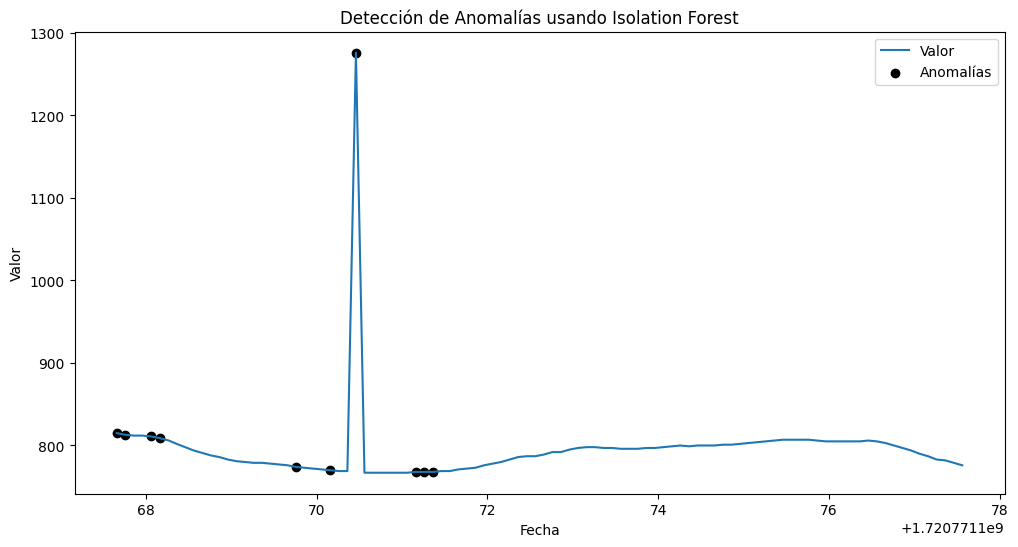

ROC: 0.9545454545454545


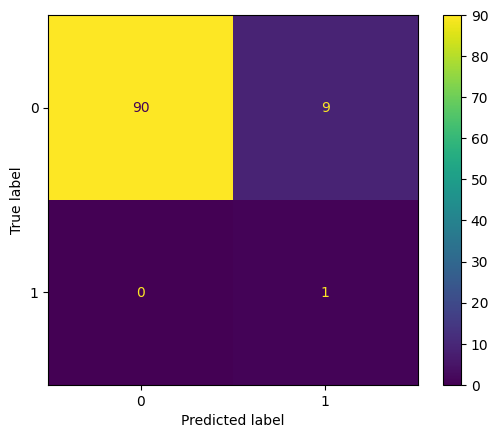

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

predictions_all = {}

df = vicomtech_data(pct_cambio = .5, pct_filas = 0.03)
# df = df[['Timestamp (UNIX) ', 'Speed (cm/s)', 'label']]
df = df.head(100)

# Aplicar Isolation Forest
model = IsolationForest(contamination=0.1)  
df['anomaly'] = model.fit_predict(df[['Speed (cm/s)']])

# Visualizar las anomalías
anomalies = df[df['anomaly'] == -1]

predictions_all['IForest'] = df['anomaly'].apply(lambda x: 0 if x == 1 else 1)
predictions_all['Real'] = df['label']

plt.figure(figsize=(12, 6))
plt.plot(df[['Timestamp (UNIX) ']], df[['Speed (cm/s)']], label='Valor')
plt.scatter(anomalies[['Timestamp (UNIX) ']], anomalies[['Speed (cm/s)']], color='black', label='Anomalías')
# plt.scatter(df.loc[df['label'] == 1, 'Timestamp (UNIX) '], df.loc[df['label'] == 1, 'Speed (cm/s)'], color='red', label='Anomalías')
plt.title('Detección de Anomalías usando Isolation Forest')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

evaluate(df['label'], predictions_all['IForest'])

---
# Autoencoder

1. Importación de librerías:

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from pyod.utils.data import evaluate_print

2024-07-22 09:57:18.199529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 09:57:18.219659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 09:57:18.243725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 09:57:18.250939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 09:57:18.269538: I tensorflow/core/platform/cpu_feature_guar

2. Carga de la serie temporal:

In [21]:
# Cargar datos de series temporales
df = vicomtech_data(pct_cambio = 0.3, pct_filas = 0.03)
# df = df[['Timestamp (UNIX) ', 'Speed (cm/s)', 'Longitudinal acceleration', 'label']]
data = df.head(2500)
columns = ['Timestamp (UNIX) ', 'Speed (cm/s)'] #'Longitudinal acceleration'
# columns = ['Timestamp (UNIX) ', 'Speed (cm/s)']
serie_temporal_multivariable = data[columns]

# Normalizar la serie temporal multivariante
serie_normalizada = (serie_temporal_multivariable - serie_temporal_multivariable.mean()) / serie_temporal_multivariable.std()


3. Definición del modelo autoencoder multivariante:

In [22]:
# Definir el modelo autoencoder multivariante
def crear_autoencoder_multivariante(dim_entrada):
  # Capa de entrada
  entrada = layers.Input(shape=(dim_entrada,))

  # Capa codificadora
  codificador = layers.Dense(64, activation='relu')(entrada)
  codificador = layers.Dense(32, activation='relu')(codificador)

  # Capa decodificadora
  decodificador = layers.Dense(32, activation='relu')(codificador)
  decodificador = layers.Dense(dim_entrada, activation='linear')(decodificador)

  # Modelo
  modelo = Model(entrada, decodificador)
  modelo.compile(loss='mse', optimizer='adam')
  return modelo

# Crear el modelo autoencoder multivariante
dim_entrada = len(serie_normalizada.columns)
modelo_autoencoder_multivariante = crear_autoencoder_multivariante(dim_entrada)

4. Entrenamiento del modelo:

In [18]:
# Entrenar el modelo autoencoder multivariante
historia = modelo_autoencoder_multivariante.fit(serie_normalizada.values, 
                                               serie_normalizada.values, 
                                               epochs=10, 
                                               batch_size=100)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8039
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2292 
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0666 
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0232 
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041 
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012     
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4969e-04 
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9494e-04 


5. Detección de anomalías:

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


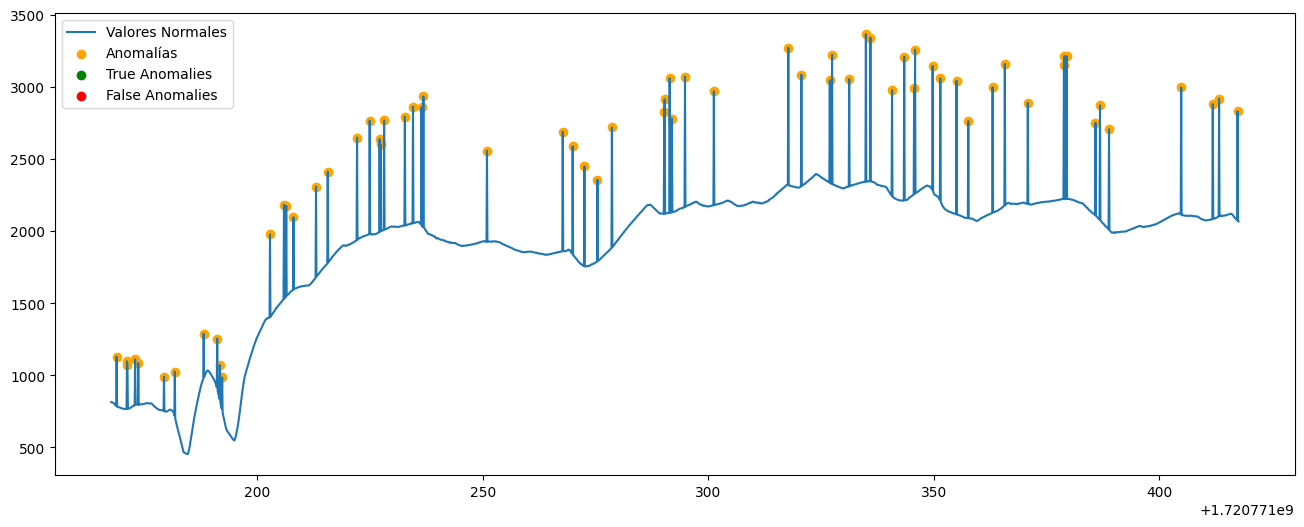

ROC: 0.5


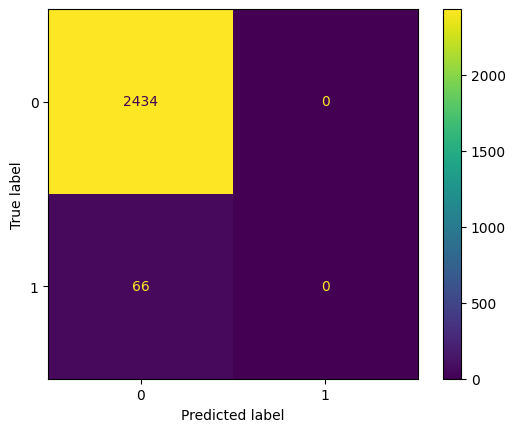

In [19]:
# Umbral de reconstrucción
umbral = np.percentile(historia.history['loss'], 99)

# Predicción de la serie temporal normalizada
serie_reconstruida = modelo_autoencoder_multivariante.predict(serie_normalizada.values)

# Detección de anomalías
anomalias = serie_normalizada[np.linalg.norm(serie_normalizada.values - serie_reconstruida, axis=1) > umbral]

# Info
l1 = list(set(anomalias.index))
l2 = list(set(data.loc[data['label'] == 1].index))
labels_pred = np.zeros(len(data))
labels_real = np.zeros(len(data))
labels_pred[l1] = 1
labels_real[l2] = 1

# Gráfica
plt.figure(figsize=(16, 6))
# All points
plt.plot(data[columns[0]], data[columns[1]], label='Valores Normales')
# Real anomalies
plt.scatter(data.loc[data['label'] == 1, columns[0]], data.loc[data['label'] == 1, columns[1]], color='orange', label='Anomalías')
# Predicted anomalies
plt.scatter(data.loc[anomalias.index, columns[0]], data.loc[anomalias.index, columns[1]], color='green', label='True Anomalies')
# Wrong predicted
wrong_predicted = list(set(anomalias.index) - set(data.loc[data['label'] == 1].index))
plt.scatter(data.loc[wrong_predicted, columns[0]], data.loc[wrong_predicted, columns[1]], color='red', label='False Anomalies')
plt.legend()
plt.show()

evaluate(labels_real, labels_pred)

## With DIFF

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4065
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2112 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2781 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2522 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1539 
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2039 
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1645 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9306 
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9482 
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9401 
[2.366300582885742, 2.3177807331085205, 2.3421666622161865, 2.229135751724243, 2.191589593887329, 2.1561343669891357, 2.180497407913208, 2.01511287689209, 1.9914871454238892, 1.973158359527588]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
ROC: 0.7551020408163265


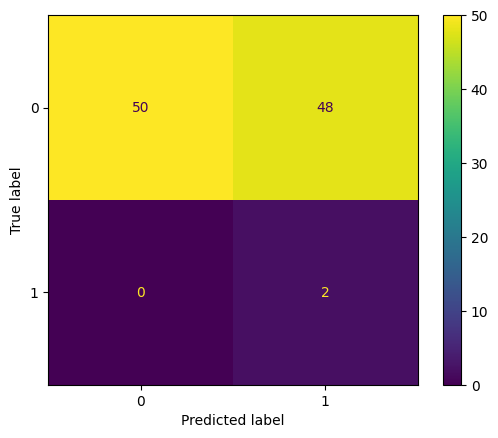

In [66]:
# Cargar datos de series temporales
df = vicomtech_data(pct_cambio = .3, pct_filas = 0.03)
# df = df[['Timestamp (UNIX) ', 'Speed (cm/s)', 'Longitudinal acceleration', 'label']]
data = df.head(100)

columns = data.columns
# columns = ['Timestamp (UNIX) ', 'Speed (cm/s)', 'Longitudinal acceleration'] #'Longitudinal acceleration'
# columns = ['Timestamp (UNIX) ', 'Latitude']
# columns = ['Timestamp (UNIX) ', 'Speed (cm/s)']
serie_temporal_multivariable = data[columns]

# Normalizar la serie temporal multivariante
serie_normalizada = (serie_temporal_multivariable - serie_temporal_multivariable.mean()) / serie_temporal_multivariable.std()
# Definir el modelo autoencoder multivariante
def crear_autoencoder_multivariante(dim_entrada):
    entrada = layers.Input(shape=(dim_entrada,))

    # Encoder with batch normalization
    codificador = layers.Dense(64, activation='relu')(entrada)
    codificador = layers.BatchNormalization()(codificador)
    codificador = layers.Dense(32, activation='relu')(codificador)
    codificador = layers.BatchNormalization()(codificador)

    # Decoder with batch normalization
    decodificador = layers.Dense(32, activation='relu')(codificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dense(dim_entrada, activation='linear')(decodificador)

    modelo = Model(entrada, decodificador)
    modelo.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    return modelo

# Crear el modelo autoencoder multivariante
dim_entrada = len(serie_normalizada.columns)
modelo_autoencoder_multivariante = crear_autoencoder_multivariante(dim_entrada)

# Entrenar el modelo autoencoder multivariante
historia = modelo_autoencoder_multivariante.fit(serie_normalizada.values, 
                                               serie_normalizada.values, 
                                               epochs=10, 
                                               batch_size=64,
                                               )

# Umbral de reconstrucción
umbral = np.percentile(historia.history['loss'], 99)
print(historia.history['loss'])

# Predicción de la serie temporal normalizada
serie_reconstruida = modelo_autoencoder_multivariante.predict(serie_normalizada.values)

# Detección de anomalías
anomalias = serie_normalizada[np.linalg.norm(serie_normalizada.values - serie_reconstruida, axis=1) > umbral]

# Info
l1 = list(set(anomalias.index))
l2 = list(set(data.loc[data['label'] == 1].index))
labels_pred = np.zeros(len(data))
labels_real = np.zeros(len(data))
labels_pred[l1] = 1
labels_real[l2] = 1

evaluate(labels_real, labels_pred)

predictions_all['Autoencoder'] = labels_pred

## Local Anomaly

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: nan
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: nan
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: nan
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: nan
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: nan
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: nan
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: nan
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: nan
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: nan
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: nan
nan
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: nan
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: nan
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: nan
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: nan
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: nan
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/

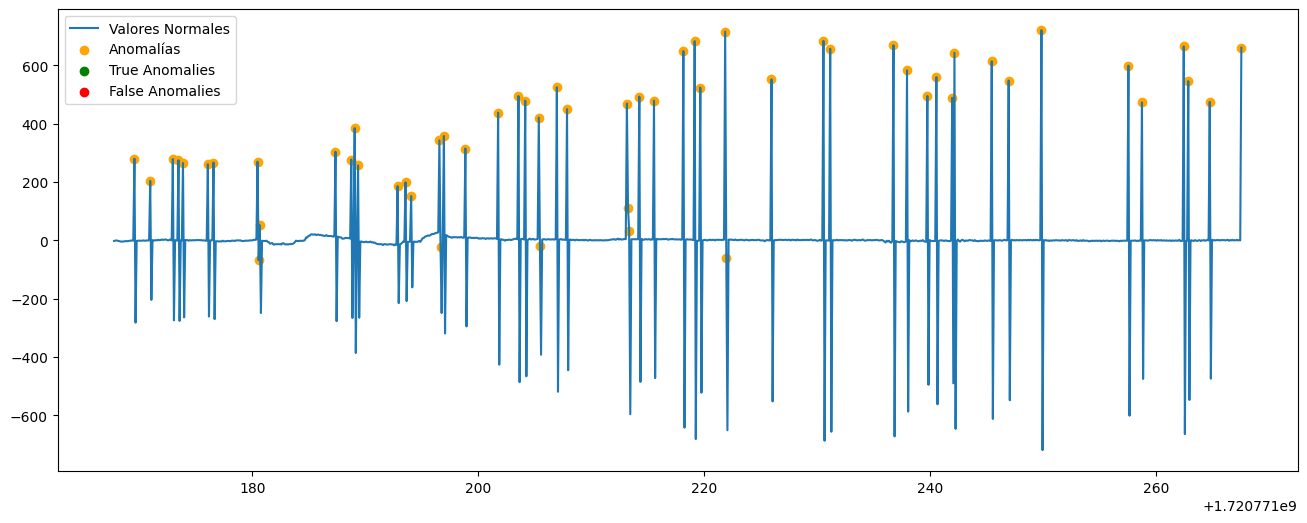

[[944   0]
 [ 56   0]]


In [98]:
# Cargar datos de series temporales
df = vicomtech_data(pct_cambio = 0.25, pct_filas = 0.05)
# df = df[['Timestamp (UNIX) ', 'Speed (cm/s)', 'Longitudinal acceleration', 'label']]
data = df.head(1000)
columns = ['Timestamp (UNIX) ', 'Speed (cm/s)'] #'Longitudinal acceleration'
# columns = ['Timestamp (UNIX) ', 'Speed (cm/s)']
data['Speed (cm/s)'] = data['Speed (cm/s)'].diff()
serie_temporal_multivariable = data[columns]

# Normalizar la serie temporal multivariante
serie_normalizada = (serie_temporal_multivariable - serie_temporal_multivariable.mean()) / serie_temporal_multivariable.std()

# Crear el modelo autoencoder multivariante
dim_entrada = len(serie_normalizada.columns)
modelo_autoencoder_multivariante = crear_autoencoder_multivariante(dim_entrada)

anomalias = serie_normalizada.iloc[[]]
step = 50
data_small = data
for rango in range(0,len(serie_normalizada), step):
    rango_min = rango
    rango_max = rango + step
    serie_normalizada_small = serie_normalizada[rango_min:rango_max]
    # Entrenar el modelo autoencoder multivariante
    historia = modelo_autoencoder_multivariante.fit(serie_normalizada_small.values, 
                                                serie_normalizada_small.values, 
                                                epochs=10, 
                                                batch_size=100)

    # Umbral de reconstrucción
    umbral = np.percentile(historia.history['loss'], 99)
    print(np.percentile(historia.history['loss'], 99))

    # Predicción de la serie temporal normalizada
    serie_reconstruida = modelo_autoencoder_multivariante.predict(serie_normalizada_small.values)

    # Detección de anomalías
    anomalias = pd.concat([anomalias, serie_normalizada_small[np.linalg.norm(serie_normalizada_small.values - serie_reconstruida, axis=1) > umbral]], ignore_index=True)
    # anomalias = serie_normalizada_small[np.linalg.norm(serie_normalizada_small.values - serie_reconstruida, axis=1) > umbral]

# Info
l1 = list(set(anomalias.index))
l2 = list(set(data_small.loc[data_small['label'] == 1].index))
labels_pred = np.zeros(len(data_small))
labels_real = np.zeros(len(data_small))
labels_pred[l1] = 1
labels_real[l2] = 1
evaluate_print("Vote", labels_real, labels_pred)

# Gráfica
plt.figure(figsize=(16, 6))
# All points
plt.plot(data_small[columns[0]], data_small[columns[1]], label='Valores Normales')
# Real anomalies
plt.scatter(data_small.loc[data_small['label'] == 1, columns[0]], data_small.loc[data_small['label'] == 1, columns[1]], color='orange', label='Anomalías')
# Predicted anomalies
plt.scatter(data_small.loc[anomalias.index, columns[0]], data_small.loc[anomalias.index, columns[1]], color='green', label='True Anomalies')
# Wrong predicted
wrong_predicted = list(set(anomalias.index) - set(data_small.loc[data_small['label'] == 1].index))
plt.scatter(data_small.loc[wrong_predicted, columns[0]], data_small.loc[wrong_predicted, columns[1]], color='red', label='False Anomalies')
plt.legend()
plt.show()


# Mayority Vote

0     1
1     1
2     0
3     0
4     1
     ..
95    0
96    0
97    0
98    0
99    0
Name: anomaly, Length: 100, dtype: int64
ROC: 0.47959183673469385


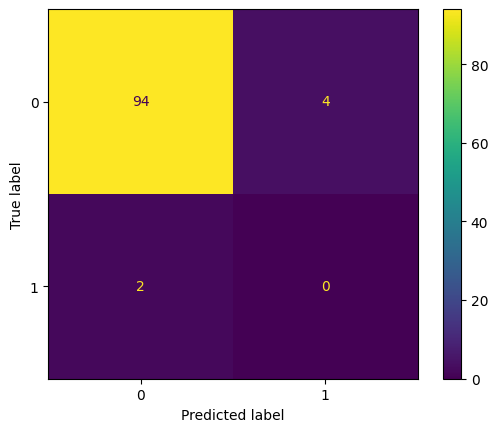

In [77]:
vote = np.logical_and(predictions_all['IForest'], predictions_all['Autoencoder']).astype(int)

print(predictions_all['IForest'])
evaluate(predictions_all['Real'], vote)